# Contents of this notebook

This notebook contains miscellaneous analysis and code that was run to accomplish this task. Particularly some data wrangling done to map physician IDs to NPIs some initial linear modeling that was done, as well as the cross validation results.

# Loading the data

In [35]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from __future__ import division

##  Loading Payments Data

In [2]:
payments_types = {'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID': 'str',
 'Charity_Indicator': 'str',
 'City_of_Travel': 'str',
 'Contextual_Information': 'str',
 'Country_of_Travel': 'str',
 'NDC_of_Associated_Covered_Drug_or_Biological1': 'str',
 'NDC_of_Associated_Covered_Drug_or_Biological2': 'str',
 'NDC_of_Associated_Covered_Drug_or_Biological3': 'str',
 'NDC_of_Associated_Covered_Drug_or_Biological4': 'str',
 'NDC_of_Associated_Covered_Drug_or_Biological5': 'str',
 'Name_of_Associated_Covered_Device_or_Medical_Supply1': 'str',
 'Name_of_Associated_Covered_Device_or_Medical_Supply2': 'str',
 'Name_of_Associated_Covered_Device_or_Medical_Supply3': 'str',
 'Name_of_Associated_Covered_Device_or_Medical_Supply4': 'str',
 'Name_of_Associated_Covered_Device_or_Medical_Supply5': 'str',
 'Name_of_Associated_Covered_Drug_or_Biological1': 'str',
 'Name_of_Associated_Covered_Drug_or_Biological2': 'str',
 'Name_of_Associated_Covered_Drug_or_Biological3': 'str',
 'Name_of_Associated_Covered_Drug_or_Biological4': 'str',
 'Name_of_Associated_Covered_Drug_or_Biological5': 'str',
 'Name_of_Third_Party_Entity_Receiving_Payment_or_Transfer_of_Value': 'str',
 'Physician_License_State_code2': 'str',
 'Physician_License_State_code3': 'str',
 'Physician_License_State_code4': 'str',
 'Physician_License_State_code5': 'str',
 'Physician_First_Name': 'str',
 'Physician_Last_Name': 'str',
 'Physician_Middle_Name': 'str',
 'Physician_Name_Suffix': 'str',
 'Physician_Profile_ID': 'str',
 'Recipient_Postal_Code': 'str',
 'Recipient_Primary_Business_Street_Address_Line2': 'str',
 'Recipient_Province': 'str',
 'Recipient_Zip_Code': 'str',
 'Record_ID': 'str',
 'State_of_Travel': 'str',
 'Teaching_Hospital_ID': 'str',
 'Teaching_Hospital_Name': 'str',
 'Third_Party_Equals_Covered_Recipient_Indicator': 'str'}

In [3]:
payments = pd.read_csv(r'OP_DTL_GNRL_PGYR2014_P06302016.csv', dtype=payments_types)

## Data Wrangling

In order to tie the payments data to prescribers, I had to look up the National Provider Identifier (NPI) for each physician in the payments dataset. Every prescriber in the Medicaid Part D prescriptions dataset has an NPI associated with them, but because of the law written by congress, the NPI is not to be released with the payments data. 

I used the National Plan and Provider Enumeration System's (NPPES) NPI [registry](https://npiregistry.cms.hhs.gov/) to lookup each physician's NPI. The code I used to do this is listed below, but it is not included in the live notebook because of memory constraints. The NPPES full dataset is over 5.7GB.



```python
physician_info = payments[['Physician_Profile_ID', 'Physician_First_Name', 'Physician_Middle_Name',
       'Physician_Last_Name', 'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_City',
       'Recipient_State']]
       
nppes = pd.read_csv(r'data_unzipped/NPPES/npidata_20050523-20170108.csv', 
                    usecols=['NPI', 'Provider Last Name (Legal Name)','Provider First Name', 
                             'Provider Middle Name', 
                             'Provider First Line Business Mailing Address',
                             'Provider Business Mailing Address City Name', 
                             'Provider Business Mailing Address State Name'], 
                    dtype={'Provider Business Mailing Address Postal Code': 'str'})
                    
# change the column names to match for merging
nppes.columns = ['NPI', 'last_name', 'first_name', 'middle_name', 'address', 'city', 'state']
physician_info.columns = ['Physician_Profile_ID', 'first_name', 'middle_name', 'last_name', 'address', 
                          'city', 'state']
                          
def safe_upper(x):
    """
    Transforms an object to an uppercase string or returns the object
    in the case it is not a string.
    """
    try:
        return x.upper()
    except AttributeError:
        return x

# make all the fields into uppercase
physician_info['first_name'] = physician_info['first_name'].apply(lambda x: safe_upper(x))
physician_info['last_name'] = physician_info['last_name'].apply(lambda x: safe_upper(x))
physician_info['middle_name'] = physician_info['middle_name'].apply(lambda x: safe_upper(x))
physician_info['address'] = physician_info['address'].apply(lambda x: safe_upper(x))
physician_info['city'] = physician_info['city'].apply(lambda x: safe_upper(x))


# drop any duplicate entries in the physicians info
physician_info = physician_info.drop_duplicates()

physician_npi = physician_info.merge(nppes, on=['last_name', 'first_name', 
                                                'middle_name', 'address', 
                                                'city', 'state'], how='inner')
# Drop any duplicates from the resulting merge
physician_npi = physician_npi[~physician_npi.duplicated(subset=['last_name', 'first_name', 
                                                                'middle_name','address', 
                                                                'city', 'state'] ,keep=False)]
                                                                
physician_id_to_npi = physician_npi[['Physician_Profile_ID', 'NPI']]

```

With this lookup we can find an NPI for 44% of the Physicians in the payments dataset. This isn't ideal, but it should give us a good cross-section on the prescription dataset.

I have this mapping saved as a pickled object, so for the live notebook all I have to do is load it using pickle.

In [4]:
file_in = open(r'physician_id_to_npi.pkl', 'rb')

physician_id_to_npi = pickle.load(file_in)

file_in.close()

### Prescriptions with NPI coverage

It's also important that we get a significant cross-section of providers from the prescriptions dataset and the payments dataset.

To measure that we will see how many NPIs in the prescriptions dataset we came up with in the NPI to physician ID mapping table.

For 36% of the prescription records we have information on that provider's payments from drug manufacturers. I don't know what percentage of all physicians receive payments from drug manufacturers so I can't quantify what proportion of physicians we aren't able to tie their prescriptions to their payments, but 36% of all prescription records from 2014 is a good sample size.

```python
len(prescriptions[prescriptions.NPI.isin(physician_id_to_npi.NPI)]) / float(len(prescriptions))
>>> 0.3598...
```

My method of looking up NPIs from the payments dataset is imperfect, because of this, I can't confidently say that the  providers in the prescription data set that I can't match up with the payments data set, have not received any payments from manufacturers. For this reason I am choosing not to include those providers my analysis. **I think I should reword this, it's a confusing sentence**

Unfortunately, this means I'm throwing away the majority of my prescription data, and I also cannot compare providers who recieve payments to those who receive no payments.

My sampling bias here means my dataset is biased toward those providers who have recieve payments from manufacturers. Outside of that, there shouldn't be any other factor influencing which providers I'm including in my analysis.

I have saved the prescription dataset I'm working with as a pickled object for memory efficiency reasons, below is the line of code I used to get the dataset I'm working with.

```python
prescriptions = prescriptions[prescriptions.NPI.isin(physician_id_to_npi.NPI)]
```

## Load Prescription Data

In [9]:
in_file = open(r'prescriptions.pkl', 'rb')
prescriptions = pickle.load(in_file)
in_file.close()

## Distribution over variables of interest

In [11]:
prescriptions[['TOTAL_CLAIM_COUNT', 'TOTAL_DAY_SUPPLY']].describe()

,TOTAL_CLAIM_COUNT,TOTAL_DAY_SUPPLY
count,8.743650e+06,8.743650e+06
mean,5.716460e+01,2.306533e+03
std,9.671093e+01,4.118261e+03
min,1.100000e+01,1.100000e+01
25%,1.500000e+01,4.850000e+02
50%,2.600000e+01,9.900000e+02
75%,5.700000e+01,2.262000e+03
max,1.508500e+04,2.436100e+05


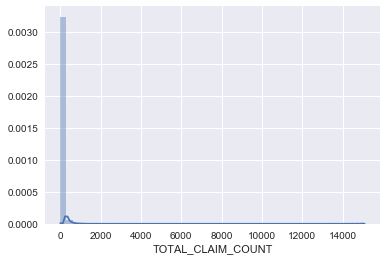

In [12]:
sns.distplot(prescriptions.TOTAL_CLAIM_COUNT)
None

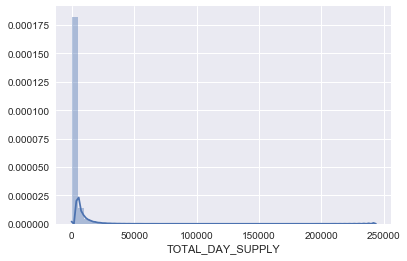

In [13]:
sns.distplot(prescriptions.TOTAL_DAY_SUPPLY)
None

Both variables of interest exhibit a highly tailed distribution. There are definitely significant outliers in the dataset.

# Loading in the data matrix

In [2]:
in_file = open(r'total_day_supply.pkl', 'rb')

total_day_supply = pickle.load(in_file)

in_file.close()

In [3]:
in_file = open(r'y_data.pkl', 'rb')

total_claim_count = pickle.load(in_file)

in_file.close()

In [4]:
in_file = open(r'features.pkl', 'rb')

features = pickle.load(in_file)

in_file.close()

In [5]:
from scipy.sparse import csr_matrix

In [6]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix(( loader['data'], loader['indices'], loader['indptr']), shape = loader['shape'])

In [7]:
X = load_sparse_csr('data_matrix_one-hot.npz')

In [8]:
X.shape

(8743650, 4122)

# Lets run some models

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

In [10]:
X_train,X_test, supply_train, supply_test, claim_train, claim_test = train_test_split(X, total_day_supply, total_claim_count)

In [11]:
def fit_default(classifier, x_train, x_test, y_train, y_test):
    classifier.fit(x_train, y_train)
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    return (train_score, test_score)

In [12]:
tr_scr, tst_scr = fit_default(SGDRegressor(), X_train, X_test, supply_train, supply_test)
print("SGD Regressor on total day supply had a training accuracy of {} and a testing accuracy of {}".format(tr_scr, tst_scr))

SGD Regressor on total day supply had a training accuracy of -1.13850362339e+31 and a testing accuracy of -1.99078062531e+31


In [13]:
tr_scr, tst_scr = fit_default(SGDRegressor(), X_train, X_test, claim_train, claim_test)
print("SGD Regressor on total claims had a training accuracy of {} and a testing accuracy of {}".format(tr_scr, tst_scr))

SGD Regressor on total claims had a training accuracy of -1.85722329223e+34 and a testing accuracy of -1.76172631479e+34


## SGD...not so good

The default scoring function for the SGD classifier is $R^{2}$. An $R^{2}$ of zero indicates that the predicted line is simply predicting the average for the target variable. In this case the $R^{2}$ value is very close to zero and slightly negative. 

So this is by no exagerration an awful predictor.

## Cross validation results from random forest

In [164]:
in_file = open('cv_results.pkl', 'rb')
cv_results = pickle.load(in_file)
in_file.close()

in_file = open(r'cv_results_70-280_trees.pkl', 'rb')
results_70 = pickle.load(in_file)
in_file.close()

in_file = open(r'estimators_10_15_20_results.pkl', 'rb')
results_10 = pickle.load(in_file)
in_file.close()

in_file = open(r'cv_results_30-960.pkl', 'rb')
results_30 = pickle.load(in_file)
in_file.close()

all_results = pd.concat([cv_results, results_70, results_10, results_30])

In [167]:
all_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,168.199100,0.119900,0.272646,0.892008,None,auto,30,"{u'max_features': u'auto', u'n_estimators': 30...",2,0.257010,...,0.234434,0.889945,0.319497,0.891846,0.283464,0.892669,0.635546,0.011371,0.029616,0.001130
1,274.298900,0.109200,0.282562,0.896931,None,auto,50,"{u'max_features': u'auto', u'n_estimators': 50...",1,0.308392,...,0.279883,0.896649,0.327571,0.894319,0.279276,0.899220,0.958514,0.002676,0.033601,0.001494
0,65.734608,0.129790,0.308585,0.901858,None,NaN,70,"{u'n_estimators': 70, u'max_depth': None}",3,0.310827,...,0.297760,0.900431,0.314640,0.900591,0.306275,0.901278,0.350637,0.002049,0.016057,0.000849
1,131.277805,0.238249,0.316035,0.904124,None,NaN,140,"{u'n_estimators': 140, u'max_depth': None}",1,0.322520,...,0.320335,0.904682,0.315095,0.903823,0.310711,0.903589,0.568866,0.003949,0.011735,0.000824
2,261.344831,0.350556,0.315946,0.905359,None,NaN,280,"{u'n_estimators': 280, u'max_depth': None}",2,0.321872,...,0.321918,0.904903,0.316069,0.904712,0.315419,0.905090,0.832088,0.014093,0.010406,0.000668
3,0.805407,0.122033,0.133994,0.150324,3,NaN,70,"{u'n_estimators': 70, u'max_depth': 3}",12,0.131154,...,0.131590,0.149693,0.130157,0.146900,0.118817,0.147252,0.072117,0.004038,0.010771,0.003926
4,1.483356,0.224487,0.136346,0.151551,3,NaN,140,"{u'n_estimators': 140, u'max_depth': 3}",11,0.130118,...,0.135830,0.152401,0.139979,0.155064,0.123969,0.147867,0.015014,0.003772,0.011278,0.003382
5,2.791728,0.327700,0.136749,0.151398,3,NaN,280,"{u'n_estimators': 280, u'max_depth': 3}",10,0.130282,...,0.132725,0.149482,0.138408,0.152186,0.127187,0.148865,0.029926,0.002558,0.011136,0.003055
6,1.387093,0.124532,0.205288,0.269345,6,NaN,70,"{u'n_estimators': 70, u'max_depth': 6}",8,0.203845,...,0.196250,0.271288,0.187428,0.271101,0.216595,0.268084,0.024814,0.000771,0.016028,0.003530
7,2.574112,0.217437,0.204334,0.269277,6,NaN,140,"{u'n_estimators': 140, u'max_depth': 6}",9,0.201545,...,0.198033,0.272087,0.187292,0.271421,0.211635,0.268121,0.051165,0.036453,0.016061,0.003276


# Feature importances

In [115]:
payment_feature_importances = np.load('feature_importances.npy')

In [116]:
no_payment_feature_importances = np.load('no_payment_feature_importances.npy')

In [117]:
no_payment_features = np.load('no_payment_features.npy')

In [118]:
in_file = open('features.pkl')
payment_features = pickle.load(in_file)
in_file.close()

In [119]:
payment_features = pd.DataFrame(payment_features)
no_payment_features = pd.DataFrame(no_payment_features)
payment_features.columns = ['feature']
no_payment_features.columns = ['feature']

In [120]:
payment_features['importance'] = payment_feature_importances
no_payment_features['importance'] = no_payment_feature_importances

In [155]:
payment_features.sort_values('importance', ascending=False).head()

,feature,importance
3612,Novo Nordisk Inc,0.045810
3355,"Janssen Pharmaceuticals, Inc",0.035798
1349,LEVOTHYROXINE SODIUM,0.032142
2784,AstraZeneca Pharmaceuticals LP,0.030318
2123,SIMVASTATIN,0.029629


In [157]:
no_payment_features.sort_values('importance', ascending=False).head()

,feature,importance
1349,LEVOTHYROXINE SODIUM,0.090877
2123,SIMVASTATIN,0.085321
226,AMLODIPINE BESYLATE,0.078578
1368,LISINOPRIL,0.078518
299,ATORVASTATIN CALCIUM,0.076280
